In [1]:
import pandas as pd

In [2]:
# load the data
training_data = pd.read_csv("train.csv")

corr_matrix = training_data.corr()

In [3]:
print(corr_matrix["SalePrice"].sort_values(ascending=False))

SalePrice        1.000000
OverallQual      0.790982
GrLivArea        0.708624
GarageCars       0.640409
GarageArea       0.623431
TotalBsmtSF      0.613581
1stFlrSF         0.605852
FullBath         0.560664
TotRmsAbvGrd     0.533723
YearBuilt        0.522897
YearRemodAdd     0.507101
GarageYrBlt      0.486362
MasVnrArea       0.477493
Fireplaces       0.466929
BsmtFinSF1       0.386420
LotFrontage      0.351799
WoodDeckSF       0.324413
2ndFlrSF         0.319334
OpenPorchSF      0.315856
HalfBath         0.284108
LotArea          0.263843
BsmtFullBath     0.227122
BsmtUnfSF        0.214479
BedroomAbvGr     0.168213
ScreenPorch      0.111447
PoolArea         0.092404
MoSold           0.046432
3SsnPorch        0.044584
BsmtFinSF2      -0.011378
BsmtHalfBath    -0.016844
MiscVal         -0.021190
Id              -0.021917
LowQualFinSF    -0.025606
YrSold          -0.028923
OverallCond     -0.077856
MSSubClass      -0.084284
EnclosedPorch   -0.128578
KitchenAbvGr    -0.135907
Name: SalePr

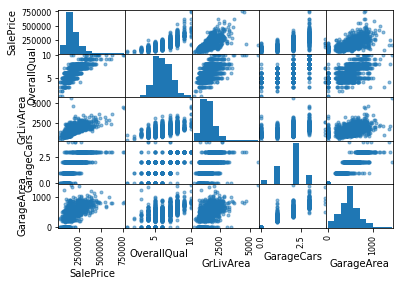

In [4]:
# Plot the correlations of some of the most promising features.
from pandas.tools.plotting import scatter_matrix
import matplotlib.pyplot as plt
%matplotlib inline
attributes = ["SalePrice", "OverallQual", "GrLivArea", "GarageCars", "GarageArea"]
scatter_matrix(training_data[attributes])
plt.show()

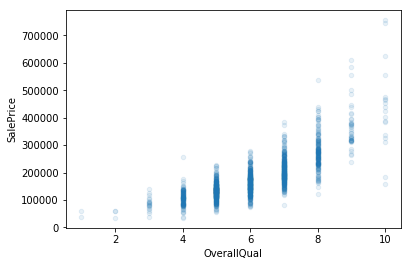

In [5]:
# Let's have a closer look at the relationship between overall quality and sale price, 
# since it appears to be the most promising.
training_data.plot(kind="scatter", x="OverallQual", y="SalePrice", alpha=0.1)

In [6]:
# Drop the target label from the training data
train = training_data.drop("SalePrice", axis=1)

train_labels = training_data["SalePrice"]
# Figure out how much missing data there is for each feature.
num_missing = train.isnull().sum().sort_values(ascending=False)
print(num_missing[num_missing>0])

PoolQC          1453
MiscFeature     1406
Alley           1369
Fence           1179
FireplaceQu      690
LotFrontage      259
GarageCond        81
GarageType        81
GarageYrBlt       81
GarageFinish      81
GarageQual        81
BsmtExposure      38
BsmtFinType2      38
BsmtCond          37
BsmtQual          37
BsmtFinType1      37
MasVnrArea         8
MasVnrType         8
Electrical         1
dtype: int64


In [7]:
# Are any of these features correlated with other features? If there are we can drop some correlated features.
c = train.corr().abs()

print(c)

                     Id  MSSubClass  LotFrontage   LotArea  OverallQual  \
Id             1.000000    0.011156     0.010601  0.033226     0.028365   
MSSubClass     0.011156    1.000000     0.386347  0.139781     0.032628   
LotFrontage    0.010601    0.386347     1.000000  0.426095     0.251646   
LotArea        0.033226    0.139781     0.426095  1.000000     0.105806   
OverallQual    0.028365    0.032628     0.251646  0.105806     1.000000   
OverallCond    0.012609    0.059316     0.059213  0.005636     0.091932   
YearBuilt      0.012713    0.027850     0.123349  0.014228     0.572323   
YearRemodAdd   0.021998    0.040581     0.088866  0.013788     0.550684   
MasVnrArea     0.050298    0.022936     0.193458  0.104160     0.411876   
BsmtFinSF1     0.005024    0.069836     0.233633  0.214103     0.239666   
BsmtFinSF2     0.005968    0.065649     0.049900  0.111170     0.059119   
BsmtUnfSF      0.007940    0.140759     0.132644  0.002618     0.308159   
TotalBsmtSF    0.015415  

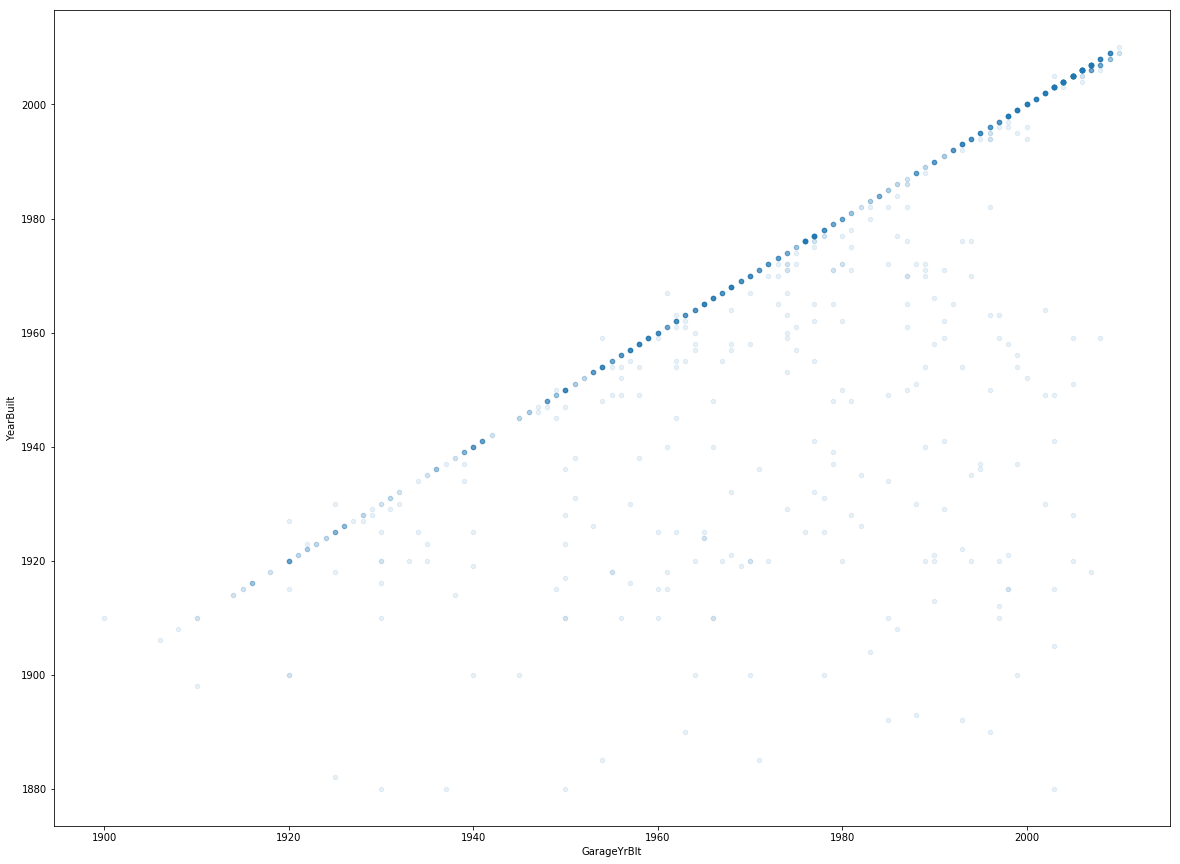

In [8]:
# How should we deal with missing GarageYrBuilt?
train.plot.scatter("GarageYrBlt", "YearBuilt", figsize=(20,15), alpha=0.1)

In [9]:
def drop_features(df):
    """Drop features that have a lot of missing data, or do not correlate with SalePrice."""
    # The above plot shows that garages are usually built the same year as the house. This means that 
    # we can probably drop GarageYrBlt (it has missing values) because that information is mostly
    # present in YearBuilt.
    df.drop("GarageYrBlt", inplace=True, axis=1)
    return df

def impute_data(df_input):
    """Fill missing values (NaN and Na)"""
    # Description of features available at
    # https://www.kaggle.com/c/house-prices-advanced-regression-techniques/data
    
    # Don't want to mutate the input dataframe
    df = df_input.copy()
    
    # Alley NA means that there is no access
    df["Alley"].fillna("NoAccess", inplace=True)
    
    # NA in PoolQC means that there is no pool
    df["PoolQC"].fillna("NoPool", inplace=True)
    
    # NA in MiscFeature means that there are no misc features
    df["MiscFeature"].fillna("NoFeatures", inplace=True)
    
    # NA in Fence means that there is no fence
    df["Fence"].fillna("NoFence", inplace=True)
    
    # NA in FireplaceQu means that there is no fireplace
    df["FireplaceQu"].fillna("NoFireplace", inplace=True)
    
    # I *think* that missing values in lot frontage means that there is no street attaching to property
    df["LotFrontage"].fillna(0, inplace=True)
    
    # NA in GarageCond, GarageType, GarageFinish, GarageQual all mean that there is no garage
    garage_features_to_fill = ["GarageCond", "GarageType", "GarageFinish", "GarageQual"]
    for f in garage_features_to_fill:
        df[f].fillna("NoGarage", inplace=True)
    
    # NA in BsmtExposure, BsmtFinType1, BsmtFinType2, BsmtQual, BsmtCond means that there is no basement.
    # Although some of these seem to be missing one more value than the others, which is strange.
    basement_features_to_fill = ["BsmtExposure", "BsmtFinType1", "BsmtFinType2", "BsmtQual", "BsmtCond"]
    for f in basement_features_to_fill:
        df[f].fillna("NoBasement", inplace=True)
        
    # Assume that NA in MasVnrArea, MasVnrType means that there is no veneer.
    df["MasVnrArea"].fillna(0, inplace=True)
    df["MasVnrType"].fillna("None", inplace=True)
    
    # For electrical missing data assume the most common wiring (it's not possible that the house did not
    # have electricity).
    df["Electrical"].fillna(df["Electrical"].mode()[0], inplace=True)
    
    # There are a few numerical columns that have few (e.g. 1) missing value. Just going to fill them with 0 in 
    # interest of finishing this code. Ideally I should check whether the Na is because there is no basement/garage.
    # In production I would monitor how many entries were affected by this.
    remaining_num_cats = ["BsmtHalfBath","BsmtFullBath","BsmtFinSF2", "BsmtUnfSF", "GarageCars", "GarageArea", "BsmtFinSF1", "TotalBsmtSF"]
    for cat in remaining_num_cats:
        df[cat].fillna(0, inplace=True)
    
    return df

In [10]:
# Preprocess the data
import numpy as np

from sklearn_pandas import DataFrameMapper
from sklearn.preprocessing import LabelBinarizer, StandardScaler


preprocessed = train.copy()


def preprocess_data(df_input):
    """Perform the preprocessing on the data, filling Na"""
    df = df_input.copy() # make sure we do not modify the input dataframe.
    df = drop_features(df)
    
    # The numeric columns and categorical columns need to be handled differently
    num_columns = list(df.select_dtypes(include=[np.number]))
    cat_columns = list(df.select_dtypes(exclude=[np.number]))
    df = impute_data(df)
    
    # One hot encode categorical variables. One hot encoding is better than assigning numbers because
    # a distance metric between categorical variables may not make any sense.
    df = pd.get_dummies(df, columns=cat_columns)
    
    # Get the number of missing values (NaN and Na) for each column.
    num_missing = df.isnull().sum().sort_values(ascending=False)
    
    # sklearn ML algos do not work with missing values. Make sure there are none slipping through.
    assert(len(num_missing == 0))
    
    # Scale the numerical columns which will make some ML algorithms perform better.
    mapper = DataFrameMapper([
         (num_columns, StandardScaler())
     ])
    df = mapper.fit_transform(df)
    return df


In [11]:
# We will be using the mean squared error (competition is scored on root mean squared error)
from sklearn.metrics import mean_squared_error

# We will be using k-fold cross validation to compare algorithms
from sklearn.model_selection import cross_val_score

def print_scores(scores):
    """Utility to print the cv scores to screen"""
    #print("Scores: ", scores)
    print("Mean: ", scores.mean())
    print("Std: ", scores.std())

def evaluate_model(model, model_name, training_data, train_labels):
    train_preprocessed = preprocess_data(train.copy())
    score = cross_val_score(model, train_preprocessed, train_labels, scoring="neg_mean_squared_error")
    print("\n")
    print(model_name)
    print_scores(np.sqrt(-score))
# Try a few different models to see what works best

# Start with linear regression
from sklearn.linear_model import LinearRegression

evaluate_model(LinearRegression(), "linear regression", train, train_labels)


# Random forest
from sklearn.ensemble import RandomForestRegressor
evaluate_model(RandomForestRegressor(), "random forest", train, train_labels)

# Support vector machine
from sklearn.svm import SVR
kernels = ["linear", "poly", "rbf", "sigmoid"]
for kernel in kernels:
    evaluate_model(SVR(kernel=kernel), "SVR_" + kernel, train, train_labels)

# Gradient boosting
from sklearn.ensemble import GradientBoostingRegressor
evaluate_model(GradientBoostingRegressor(), "gradient boosting", train, train_labels)

from sklearn.ensemble import AdaBoostRegressor
evaluate_model(AdaBoostRegressor(), "adaboost", train, train_labels)



linear regression
Mean:  37107.689477
Std:  4776.14631131


random forest
Mean:  32160.896356
Std:  2249.07305815


SVR_linear
Mean:  77393.0731122
Std:  1911.78178073


SVR_poly
Mean:  81475.5486741
Std:  1901.32442443


SVR_rbf
Mean:  81484.6525979
Std:  1895.29736289


SVR_sigmoid
Mean:  81408.8460002
Std:  1895.95519375


gradient boosting
Mean:  26996.420932
Std:  2477.88456118


adaboost
Mean:  35213.60436
Std:  2715.71310351


In [12]:
from sklearn.model_selection import GridSearchCV

# Gradient boosting and random forests look promising, try find a good set of hyper-parameters for each of these.
gradient_boosting_params =  {'n_estimators':[10,100,1000], 'max_depth':[3,30,300]}
gradient_boosting = GradientBoostingRegressor()
gradient_boosting_search = GridSearchCV(gradient_boosting, gradient_boosting_params, scoring="neg_mean_squared_error",n_jobs=8)
gb_train = preprocess_data(train.copy())
gradient_boosting_search.fit(gb_train, train_labels)
print(gradient_boosting_search.best_params_)

{'max_depth': 3, 'n_estimators': 100}


In [13]:
# Hyper-parameter searchfor random forests
# Gradient boosting and random forests look promising, try find a good set of parameters for each of these.
random_forest_params =  {'n_estimators':[10,100,1000], 'max_depth':[3,30,300]}
random_forest = RandomForestRegressor()
random_forest_search = GridSearchCV(random_forest, random_forest_params, scoring="neg_mean_squared_error", n_jobs=8)
rf_train = preprocess_data(train.copy())
random_forest_search.fit(rf_train, train_labels)
print(random_forest_search.best_params_)

{'max_depth': 300, 'n_estimators': 100}


In [14]:
# Evaluate the performance of both estimators with good hyperparameters
evaluate_model(GradientBoostingRegressor(**gradient_boosting_search.best_params_), "gradient boosting", train, train_labels)

evaluate_model(RandomForestRegressor(**random_forest_search.best_params_), "random forest", train, train_labels)




gradient boosting
Mean:  27019.1939474
Std:  2713.62280016


random forest
Mean:  30980.0240396
Std:  2735.2384422


In [15]:
# After a small hyper-parameter search it looks like gradient boosting with 100 estimators and a max depth of 3
# with all other parameters set to default performs the best. 

# TODO make an ensemble with RandomForestRegressor
model = GradientBoostingRegressor(n_estimators = 100, max_depth = 3)
test_data = training_data = pd.read_csv("test.csv")

# Fit the model to the training data
preprocessed_train = preprocess_data(train.copy())
model.fit(preprocessed_train, train_labels)

preprocessed_test = preprocess_data(test_data.copy())
# Get nan counts for the test data

predictions = model.predict(preprocessed_test)

submission_df = pd.DataFrame({
        "Id":test_data["Id"],
        "SalePrice":predictions
    })

# TODO add additional cleaning functions.
# Write the submission df to file so I can submit it to Kaggle for scoring.
submission_df.to_csv("submission.csv", index=False)